In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.markers import MarkerStyle
import cmocean
import pandas as pd
import numpy as np

In [2]:
transect_coordinates = pd.read_csv("bin_coordinates.csv") # describes bin center along the transect
transect_coordinates

,bin_lats,bin_lons
0,-63.218443,-53.651045
1,-63.303936,-53.151045
2,-63.382563,-52.651045
3,-63.471900,-52.151045
4,-63.528100,-51.651045
5,-63.615869,-51.151045
6,-63.717605,-50.651045
7,-63.832083,-50.151045
8,-63.850856,-49.651045
9,-63.921400,-49.151045


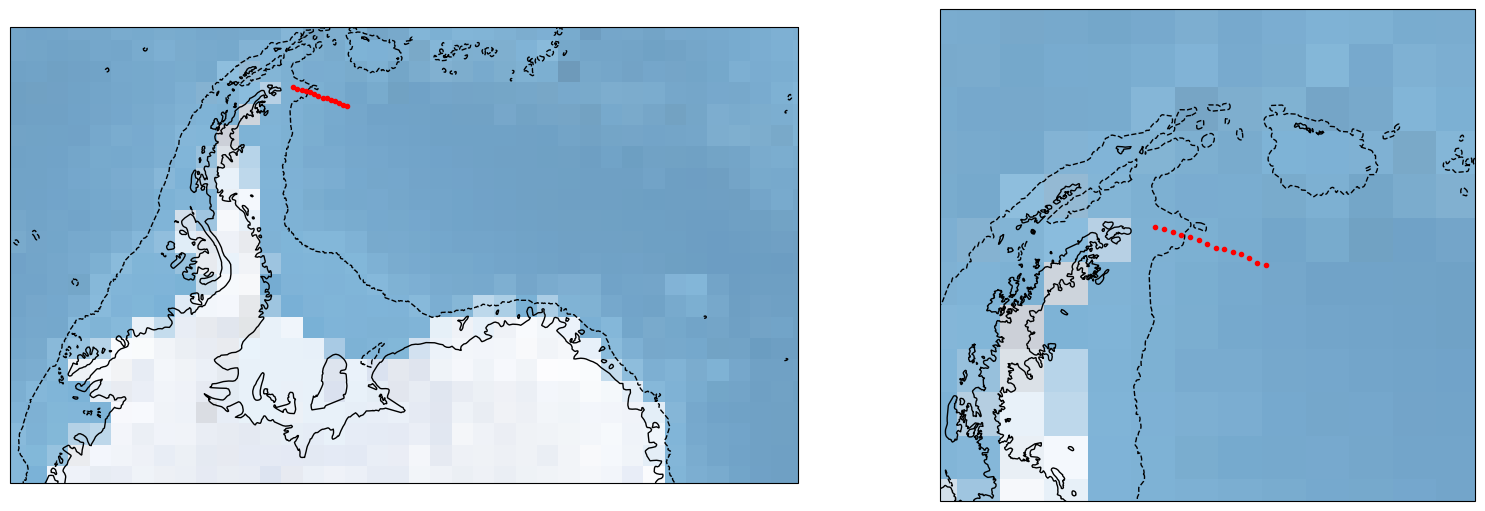

In [3]:
# Create the plot with a South Polar Stereographic projection
fig, ax = plt.subplots(ncols = 2, layout = "constrained", figsize=(16,5), subplot_kw=dict(projection=ccrs.SouthPolarStereo(central_longitude=-50)))
ax[0].coastlines()
ax[0].stock_img()
ax[0].set_extent([-85, 10, -80, -60], crs=ccrs.PlateCarree())
ax[0].plot(transect_coordinates["bin_lons"],transect_coordinates["bin_lats"],"r.",transform=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].stock_img()
ax[1].set_extent([-63, -38, -70, -57], crs=ccrs.PlateCarree())
ax[1].plot(transect_coordinates["bin_lons"],transect_coordinates["bin_lats"],"r.",transform=ccrs.PlateCarree())

# cartopy magic to add the 1000m isobath, taken from https://github.com/SciTools/cartopy/issues/1586
from shapely.ops import unary_union
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))
from shapely.geometry import JOIN_STYLE
delta = 0.0001 #Increase eps depending on your contour resolution
bathym = bathym.buffer(delta, 1, join_style=JOIN_STYLE.mitre).buffer(-delta, 1, join_style=JOIN_STYLE.mitre)
ax[0].add_geometries(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1, crs=ccrs.PlateCarree())
ax[1].add_geometries(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1, crs=ccrs.PlateCarree())

In [4]:
binned_neutral_density = pd.read_csv("./binned_neutral_density.csv", index_col = 0)
binned_neutral_density.columns = binned_neutral_density.columns.astype("float") #convert column names from strings to floats
binned_neutral_density

,-53.901045,-53.401045,-52.901045,-52.401045,-51.901045,-51.401045,-50.901045,-50.401045,-49.901045,-49.401045,-48.901045,-48.401045,-47.901045,-47.401045
0,28.155285,28.215594,28.234504,28.348462,28.432517,28.464491,28.465705,28.479566,28.489081,28.474566,28.460273,28.451495,28.416284,28.411593
1,28.155439,28.216053,28.234206,28.348942,28.432779,28.464447,28.465556,28.479561,28.489340,28.474697,28.460855,28.451706,28.415783,28.411770
2,28.155925,28.215832,28.234601,28.348692,28.432764,28.464660,28.465557,28.479463,28.489293,28.474444,28.460745,28.451662,28.415211,28.411601
3,28.155954,28.215485,28.234115,28.348715,28.432794,28.463938,28.465434,28.479618,28.489160,28.474173,28.460714,28.451340,28.414111,28.411748
4,28.155533,28.215776,28.234084,28.349313,28.432909,28.463556,28.465472,28.479617,28.489250,28.474113,28.460517,28.450749,28.413684,28.411091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# assert the bin center and the bin edges are correctly aligned and differ by half a bin (0.25°)
assert np.all(transect_coordinates["bin_lons"] - list(binned_neutral_density.columns) == 0.25)

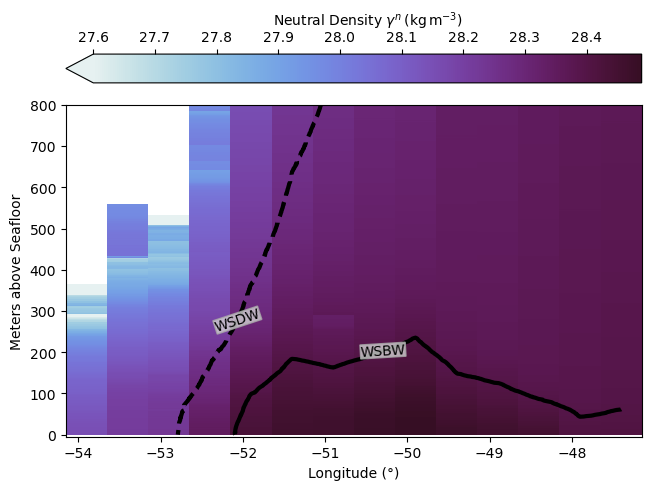

In [6]:
fig, ax = plt.subplots(1, layout = "constrained")
cmap = cmocean.cm.dense
mpp = ax.pcolormesh(
    binned_neutral_density.columns, #bin edges
    binned_neutral_density.index,   #bin meter above bottom
    binned_neutral_density,
    cmap=cmap,
    vmin = 27.6
)
cb = plt.colorbar(mpp, ax=ax, location="top", extend = "min")
cb.set_label(r"Neutral Density $\gamma^n\,$(kg$\,$m$^{-3}$)")

def draw_water_mass_boundaries(axis):
    water_mass_boundaries = [28.26, 28.40] 
    water_mass_names = ['WSDW', 'WSBW'] # water mass names
    CS = axis.contour(
        binned_neutral_density.columns,
        binned_neutral_density.index,
        binned_neutral_density,
        levels=water_mass_boundaries,
        linestyles=["dashed", "solid"],
        colors="k",
        linewidths=3,
        zorder=10
    )
    
    # labeling
    fmt = {}
    for l, s in zip(CS.levels, water_mass_names):
        fmt[l] = s
    # Label every other level using strings
    clabels = axis.clabel(
        CS,
        CS.levels,
        inline=False,
        fmt=fmt,
        colors="black",
        fontsize=10,
    )
    # adjust bboxes for better readability
    [txt.set_bbox(dict(facecolor='lightgrey', alpha = 0.8, edgecolor='darkgrey', boxstyle="round", pad=0)) for txt in clabels]

draw_water_mass_boundaries(ax)
ax.set_ylim(-5,800)
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Meters above Seafloor");

In [7]:
binned_thorpe_dissipation = pd.read_csv("./binned_thorpe_dissipation.csv", index_col = 0)
binned_thorpe_dissipation.columns = binned_thorpe_dissipation.columns.astype("float") #convert column names from strings to floats
binned_thorpe_dissipation

,-53.901045,-53.401045,-52.901045,-52.401045,-51.901045,-51.401045,-50.901045,-50.401045,-49.901045,-49.401045,-48.901045,-48.401045,-47.901045,-47.401045
mab,,,,,,,,,,,,,,
0,4.100856e-08,2.933849e-08,5.038055e-07,3.372352e-08,4.808583e-08,7.539169e-09,6.405601e-09,1.076042e-08,9.539744e-09,4.535832e-09,5.082748e-09,2.961395e-09,2.193777e-10,1.331753e-09
1,4.100856e-08,2.933849e-08,5.061775e-07,3.372352e-08,4.970542e-08,8.180532e-09,1.050969e-08,1.076042e-08,9.539744e-09,4.668933e-09,5.327785e-09,2.961395e-09,2.193777e-10,1.331753e-09
2,4.100856e-08,2.933849e-08,5.061775e-07,3.372352e-08,4.987147e-08,8.180532e-09,1.058443e-08,1.076042e-08,9.539744e-09,4.668933e-09,5.327785e-09,3.680905e-09,2.193777e-10,1.331753e-09
3,4.100856e-08,2.933849e-08,5.061476e-07,3.372352e-08,4.987147e-08,7.321407e-09,1.063774e-08,1.076042e-08,9.980895e-09,4.668933e-09,5.327785e-09,3.241058e-09,8.132914e-10,1.331753e-09
4,3.962545e-08,2.933849e-08,5.061476e-07,3.372352e-08,4.999246e-08,7.355891e-09,1.063774e-08,1.076042e-08,9.980895e-09,4.668933e-09,5.327785e-09,3.619218e-09,8.132914e-10,5.685057e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


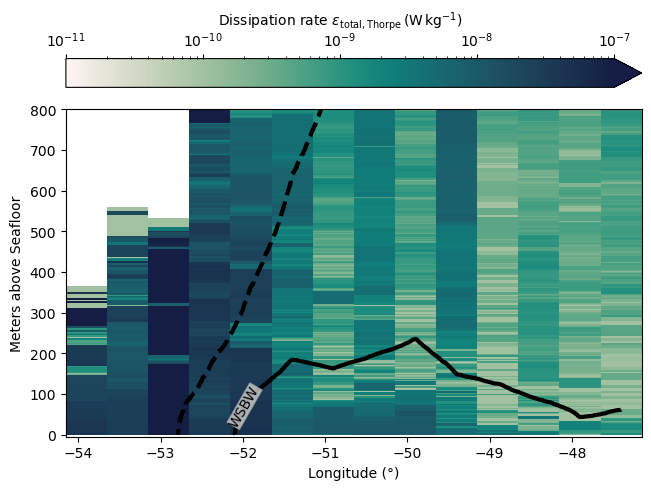

In [8]:
fig, ax = plt.subplots(1, layout = "constrained")
cmap = cmocean.cm.tempo
mpp = ax.pcolormesh(
    binned_thorpe_dissipation.columns, 
    binned_thorpe_dissipation.index, 
    binned_thorpe_dissipation,
    norm=mcolors.LogNorm(vmin=1e-11, vmax=1e-7),
    cmap=cmap,
)
ax.set_ylim(-5,800)
cb = plt.colorbar(mpp, ax=ax, location="top", extend = "max")
cb.set_label(r"Dissipation rate $\varepsilon_{\mathrm{total, Thorpe}}\,$(W$\,$kg$^{-1}$)")
draw_water_mass_boundaries(ax)
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Meters above Seafloor");

In [9]:
binned_finestructure_dissipation = pd.read_csv("./binned_finestructure_dissipation.csv", index_col = 0)
binned_finestructure_dissipation.columns = binned_finestructure_dissipation.columns.astype("float") #convert column names from strings to floats
binned_finestructure_dissipation

,-53.632214,-53.132214,-52.632214,-52.132214,-51.632214,-51.132214,-50.632214,-50.132214,-49.632214,-49.132214,-48.632214,-48.132214,-47.632214,-47.132214
mab,,,,,,,,,,,,,,
62.0,1.071675e-09,4.003219e-09,2.225574e-08,3.634673e-09,9.114408e-10,1.293118e-09,4.231375e-10,3.085110e-10,5.166190e-10,2.096908e-10,1.038537e-10,1.230020e-10,1.962738e-10,2.026007e-11
187.0,9.193158e-10,1.831857e-09,7.946681e-09,4.282095e-09,1.939178e-09,7.425760e-10,9.480321e-10,1.170371e-09,2.145479e-09,6.069233e-10,2.702900e-10,9.994908e-11,2.150557e-10,6.637798e-11
312.0,NaN,5.435337e-10,2.042952e-08,3.936229e-09,2.312068e-09,1.638685e-09,3.560296e-10,4.446692e-10,1.214240e-09,1.206314e-10,2.715232e-10,1.454540e-10,4.299571e-10,8.853008e-11
437.0,NaN,1.354501e-08,5.458688e-09,2.847732e-09,1.374882e-09,1.638477e-09,9.014058e-11,2.728933e-10,2.423020e-09,1.097747e-10,9.720521e-11,8.966870e-11,2.673863e-10,5.286483e-11
562.0,NaN,NaN,7.995941e-10,1.899836e-09,1.670035e-09,5.240481e-10,2.563617e-10,4.305252e-10,1.249346e-09,1.240074e-10,1.193133e-10,7.241046e-11,1.304400e-10,5.366614e-11
687.0,NaN,NaN,1.612132e-09,4.540196e-09,9.898447e-10,1.572952e-10,1.021252e-10,1.202226e-09,5.402241e-10,6.277514e-11,1.710690e-10,3.305097e-10,2.646238e-09,4.830494e-11
812.0,NaN,NaN,NaN,2.707089e-09,7.677721e-10,1.984557e-10,7.468184e-11,2.068903e-10,2.041302e-10,5.833310e-11,4.443846e-10,6.746355e-11,8.011249e-10,2.243208e-11
937.0,NaN,NaN,NaN,4.954359e-09,1.953338e-09,1.768449e-10,4.703331e-11,1.419894e-10,1.793377e-10,6.231134e-11,7.105642e-11,5.561759e-11,6.532945e-10,2.763065e-11
1062.0,NaN,NaN,NaN,2.323728e-08,6.052802e-10,2.721579e-10,7.047000e-11,4.599063e-10,1.777041e-10,5.495624e-11,1.426972e-10,5.741688e-11,1.421058e-10,2.165029e-11


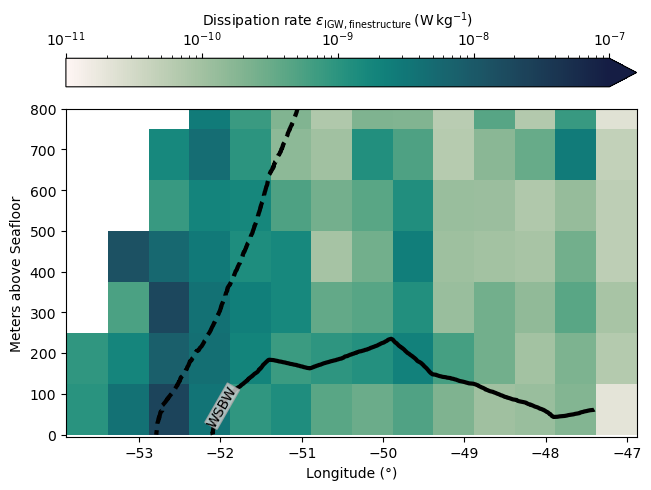

In [10]:
fig, ax = plt.subplots(1, layout = "constrained")
cmap = cmocean.cm.tempo
mpp = ax.pcolormesh(
    binned_finestructure_dissipation.columns, 
    binned_finestructure_dissipation.index, 
    binned_finestructure_dissipation,
    norm=mcolors.LogNorm(vmin=1e-11, vmax=1e-7),
    cmap=cmap,
)
ax.set_ylim(-5,800)
cb = plt.colorbar(mpp, ax=ax, location="top", extend = "max")
cb.set_label(r"Dissipation rate $\varepsilon_{\mathrm{IGW, finestructure}}\,$(W$\,$kg$^{-1}$)")
draw_water_mass_boundaries(ax)
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Meters above Seafloor");

In [11]:
wave_energy_dissipation = pd.read_csv("./wave_energy_dissipation.csv", index_col = 0)
wave_energy_dissipation

,lon,lat,rounded depth,rounded mab,barotropic,continuum,available E,E Error,N,N Error,coriolis frequency,eps_IGW,eps_IGW_mult_error,eps_IGW_add_error
index,,,,,,,,,,,,,,
0,-52.2870,-63.4032,299,343,0.000807,0.000353,0.000353,1.592056e-06,0.001586,0.000466,-0.000130,5.737885e-10,1.641828,3.375698e-10
1,-52.2870,-63.4032,505,137,0.000807,0.000559,0.000741,9.692530e-07,0.001135,0.000268,-0.000130,4.402297e-09,1.476335,2.082164e-09
2,-52.2870,-63.4032,614,28,0.000807,0.000645,0.000850,1.138264e-07,0.000614,0.000283,-0.000130,1.548914e-08,2.035173,1.428215e-08
3,-51.6357,-63.5145,1318,338,0.000423,0.000365,0.000476,5.356444e-07,0.001157,0.000225,-0.000131,1.764363e-09,1.377578,6.852385e-10
4,-51.6357,-63.5145,1513,143,0.000423,0.000544,0.000592,9.137856e-07,0.001206,0.000233,-0.000131,2.549531e-09,1.377235,9.862902e-10
5,-51.6357,-63.5145,1625,31,0.000423,0.000376,0.000376,1.388905e-07,0.000628,0.000297,-0.000131,2.919587e-09,2.076026,2.758180e-09
6,-50.8113,-63.6560,2143,350,0.000237,0.000313,0.000454,1.107861e-06,0.001097,0.000061,-0.000131,1.753330e-09,1.095109,1.938741e-10
7,-50.8113,-63.6560,2350,143,0.000237,0.000421,0.000563,1.375006e-06,0.001407,0.000168,-0.000131,1.780950e-09,1.220423,4.241559e-10
8,-50.0897,-63.7783,2400,357,0.000190,0.000498,0.000507,1.294270e-06,0.000972,0.000140,-0.000131,2.659811e-09,1.263843,7.662477e-10


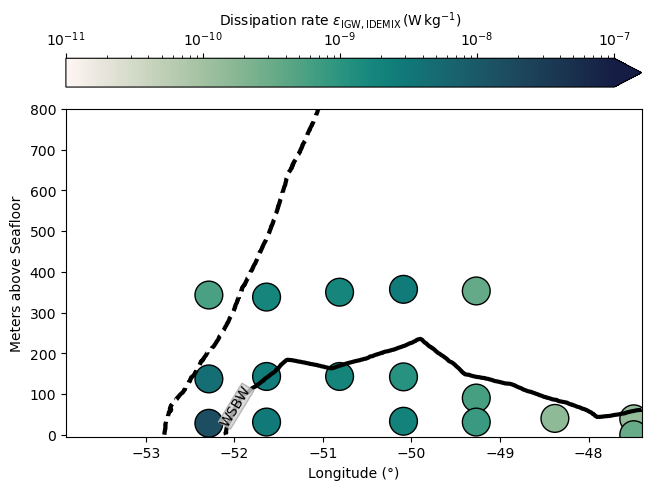

In [12]:
fig, ax = plt.subplots(1, layout = "constrained")
cmap = cmocean.cm.tempo
mpp = ax.scatter(
    wave_energy_dissipation["lon"], 
    wave_energy_dissipation["rounded mab"],
    c = wave_energy_dissipation["eps_IGW"],
    edgecolor="black",
    marker=MarkerStyle("o"),
    s = 400,
    norm=mcolors.LogNorm(vmin=1e-11, vmax=1e-7),
    cmap=cmap,
)

ax.set_ylim(-5,800)
cb = plt.colorbar(mpp, ax=ax, location="top", extend = "max")
cb.set_label(r"Dissipation rate $\varepsilon_{\mathrm{IGW, IDEMIX}}\,$(W$\,$kg$^{-1}$)")
draw_water_mass_boundaries(ax)
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Meters above Seafloor");